In [55]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom

print(tf.__version__) # 2.6.0

2.8.0


In [56]:
from pathlib import Path

# Obter todas as fotos de folha
rootPath = Path('..').resolve()
photosPath = Path(rootPath, 'fotos' )
plantPath = Path(photosPath, 'by_plant' )
folhaPath = Path(plantPath, 'folha' )
img_count = len(list(folhaPath.glob('**/*.jpg')))
print(img_count)

119


In [57]:
# Vou usar o seguinte esquema:
# 80% das imagens serão usadas para treinar a ML
# 20% para validar a precisão
batch_size = 2
img_width = 100
img_height = 100

In [58]:
# Criar dataset para treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
    folhaPath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 119 files belonging to 6 classes.
Using 96 files for training.


In [59]:
# Criar dataset para validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    folhaPath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 119 files belonging to 6 classes.
Using 23 files for validation.


In [60]:
class_names = train_ds.class_names
print( class_names )

['caesalpinia_pulcherrima', 'chamaecrista_desvauxii', 'crotalaria_retusa', 'hymenaea_coubaril', 'hymenaea_velutina', 'leucaena_leucocephala']


In [61]:
# Remover canal gama RGB (vai basicamente deixar todas as fotos em preto e branco)
normalization_layer = Rescaling(1. / 255)

In [62]:
# Normalizar imagens
normalized_ds = train_ds.map( lambda x, y: (normalization_layer(x), y) )

# Checar se a imagem agora está normalizada
# obs: uma imagem normalizada deve ter os valores
# dos pixels entre 0.0 e 1.0
image_batch, labels_batch = next( iter(normalized_ds) )
first_image = image_batch[0]
print( np.min(first_image), np.max(first_image) )

0.19215688 0.7019608


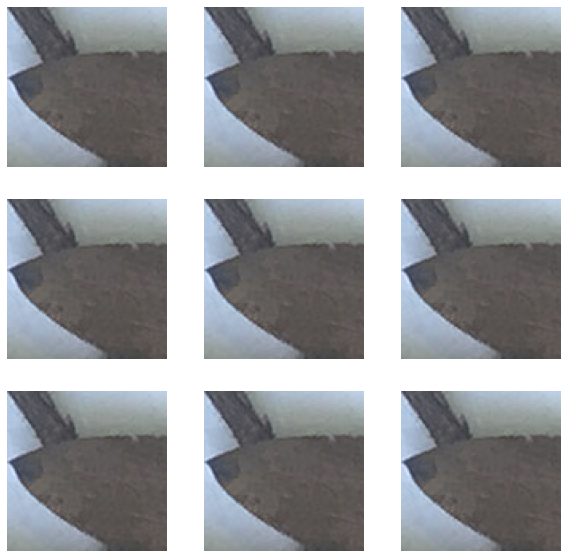

In [63]:
# Aumento de dados
# como o dataset de imagens é bem pequeno, vamos aplicar
# técnicas como zoom, espelhar e rotacionar as imagens
# existentes, criando cópias com essas modificações
# para serem inclusas no treinamento
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Visualização das imagens com modificações
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [64]:
# Criação do modelo
num_classes = 6
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

In [65]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Exibir resumo do modelo
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [66]:
# Treinar o modelo
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
48/48 [==============================] - 2s 31ms/step - loss: 1.8360 - accuracy: 0.1042 - val_loss: 1.7806 - val_accuracy: 0.0435
Epoch 2/100
48/48 [==============================] - 1s 27ms/step - loss: 1.7621 - accuracy: 0.1562 - val_loss: 1.7196 - val_accuracy: 0.0435
Epoch 3/100
48/48 [==============================] - 1s 28ms/step - loss: 1.6220 - accuracy: 0.2917 - val_loss: 1.5053 - val_accuracy: 0.5217
Epoch 4/100
48/48 [==============================] - 1s 28ms/step - loss: 1.2384 - accuracy: 0.5521 - val_loss: 1.5040 - val_accuracy: 0.5652
Epoch 5/100
48/48 [==============================] - 1s 28ms/step - loss: 1.0315 - accuracy: 0.5625 - val_loss: 1.0438 - val_accuracy: 0.7391
Epoch 6/100
48/48 [==============================] - 1s 30ms/step - loss: 0.9958 - accuracy: 0.6042 - val_loss: 1.2730 - val_accuracy: 0.5652
Epoch 7/100
48/48 [==============================] - 2s 32ms/step - loss: 0.9223 - accuracy: 0.6146 - val_loss: 1.3089 - val_accuracy: 0.5652
Epoch 

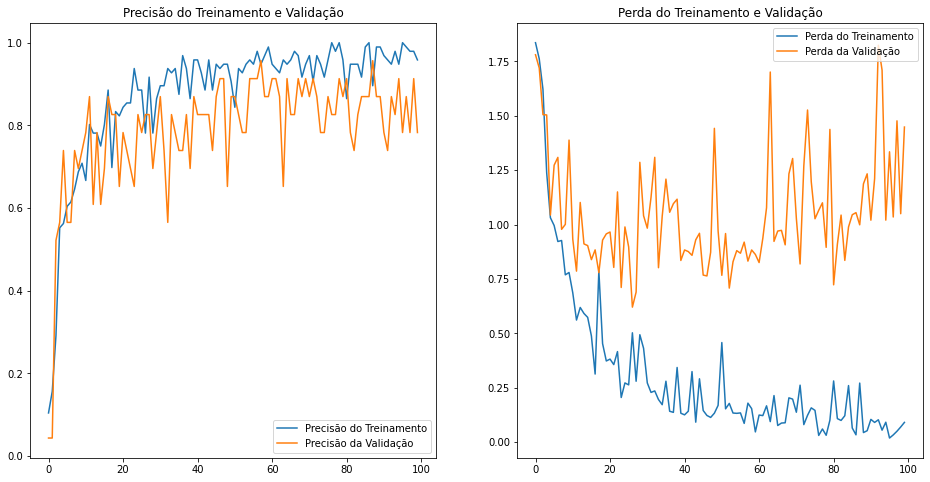

In [67]:
# Estatisticas sobre o treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plotar gráficos de precisão e perda
plt.figure( figsize=(16, 8) )
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisão do Treinamento')
plt.plot(epochs_range, val_acc, label='Precisão da Validação')
plt.legend(loc='lower right')
plt.title('Precisão do Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda do Treinamento')
plt.plot(epochs_range, val_loss, label='Perda da Validação')
plt.legend(loc='upper right')
plt.title('Perda do Treinamento e Validação')
plt.show()

In [68]:
# Testar a ML
# aqui estou usando 4 imagens, uma para cada classe, removidas da pasta 'fotos'
# para verificar se a ML realmente funciona
testPath = Path(photosPath, 'testes' )
img = tf.keras.utils.load_img(
    Path(testPath , 'FolhaCP8.jpg' ) , target_size=(img_width, img_height)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax( predictions[0] )
print( f"Essa imagem provavelmente pertence à classe '{ class_names[ np.argmax(score) ] }' com uma confiança de {(100 * np.max(score)):.2f}%" )

Essa imagem provavelmente pertence à classe 'caesalpinia_pulcherrima' com uma confiança de 100.00%


In [69]:
# Exportar o modelo
MODELS_PATH = Path( rootPath, 'models' )
MODEL_PATH = Path( MODELS_PATH, 'folha.h5' )

model.save( MODEL_PATH )